In [1]:
import math
import torch
import gpytorch
import pdb
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
y11_inds = Variable(torch.zeros(11).long())
y12_inds = Variable(torch.ones(11).long())
y2_inds = Variable(2*torch.ones(11).long())
train_y11 = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_y12 = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_y2 = Variable(torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch import ObservationModel
from gpytorch.random_variables import GaussianRandomVariable, BatchRandomVariables, CategoricalRandomVariable
from gpytorch.parameters import MLEParameterGroup, CategoricalMCParameterGroup, BoundedParameter
from torch.nn import Parameter

In [4]:
class LatentMultitaskGPModel(gpytorch.ObservationModel):
    def __init__(self,num_task_samples):
        super(LatentMultitaskGPModel,self).__init__(GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()
        self.task_covar_module = IndexKernel()

        self.model_params = MLEParameterGroup(
            constant_mean=BoundedParameter(torch.randn(1),-1,1),
            log_noise=BoundedParameter(torch.randn(1),-15,15),
            log_lengthscale=BoundedParameter(torch.randn(1),-15,15),
            task_matrix=BoundedParameter(torch.randn(2,1),-15,15),
            task_log_vars=BoundedParameter(torch.randn(2),-15,15),
        )

        task_prior = CategoricalRandomVariable(0.5*torch.ones(2))
        self.latent_tasks = CategoricalMCParameterGroup(
            task_assignments=BatchRandomVariables(task_prior,3),
        )

        self.num_task_samples = num_task_samples
        self.latent_tasks.set_options(num_samples=num_task_samples)

    def forward(self,x,i):
        n = len(x)
        mean_x = self.mean_module(x, constant=self.model_params.constant_mean)
        covar_x = self.covar_module(x, log_lengthscale=self.model_params.log_lengthscale)
        covar_i = Variable(torch.zeros(n,n))

        for j in range(self.num_task_samples):
            task_assignments = self.latent_tasks.task_assignments.sample()
            task_assignments = task_assignments.index_select(0,i)
            covar_ji = self.task_covar_module(task_assignments,
                                             index_covar_factor=self.model_params.task_matrix,
                                             index_log_var=self.model_params.task_log_vars)
            covar_i += covar_ji.mul_(1./self.num_task_samples)

        covar_xi = covar_x.mul(covar_i)
        latent_pred = GaussianRandomVariable(mean_x, covar_xi)
        return latent_pred, self.model_params.log_noise

prior_observation_model = LatentMultitaskGPModel(num_task_samples=10)

In [5]:
def plot_model_and_predictions(observation_model):
    f, (y11_ax,y12_ax,y2_ax) = plt.subplots(1, 3, figsize=(12, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    y11_inds_test = Variable(torch.zeros(51).long())
    y12_inds_test = Variable(torch.ones(51).long())
    y2_inds_test = Variable(2*torch.ones(51).long())
    
    observed_pred_y11 = observation_model(test_x,y11_inds_test)
    observed_pred_y12 = observation_model(test_x,y12_inds_test)
    observed_pred_y2 = observation_model(test_x,y2_inds_test)

    def ax_plot(ax, train_y, rand_var, title):
        lower, upper = rand_var.confidence_region()
        ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(y11_ax, train_y11, observed_pred_y11, 'Observed Values (Likelihood)')
    ax_plot(y12_ax, train_y12, observed_pred_y12, 'Observed Values (Likelihood)')
    ax_plot(y2_ax, train_y2, observed_pred_y2, 'Observed Values (Likelihood)')
    
    return f

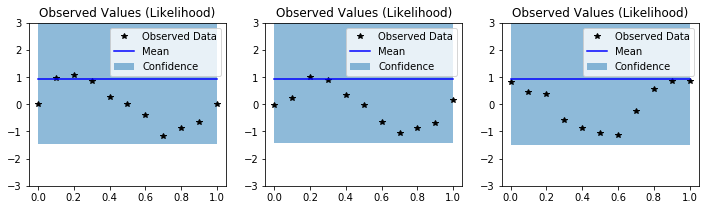

In [6]:
f = plot_model_and_predictions(prior_observation_model)

In [7]:
from gpytorch.inference import Inference

infer = Inference(prior_observation_model)
posterior_observation_model = infer.run((torch.cat([train_x,train_x,train_x]),
                                         torch.cat([y11_inds,y12_inds,y2_inds])),
                                         torch.cat([train_y11,train_y12,train_y2]),
                                         max_inference_steps=3
                                       )

0 -35.7756881714
1 -9.04814529419
2 -10.5120239258


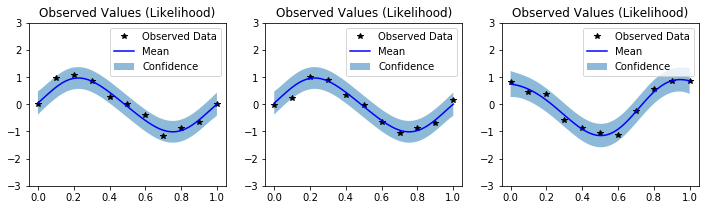

In [8]:
f = plot_model_and_predictions(posterior_observation_model)